<a href="https://colab.research.google.com/github/Sarah-wookey/RL_NetHack_2020/blob/main/Actor_Critic_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
def colab_setup():
    # install prerequisites for nle
    !sudo apt-get install -y build-essential autoconf libtool pkg-config \
        python3-dev python3-pip python3-numpy git libncurses5-dev \
        libzmq3-dev flex bison

    # download, build and install flatbuffers

    !git clone https://github.com/google/flatbuffers.git
    # all these commands have to be run in the same directory and !cd doesn't change
    # the directory permanently in colab see: 
    # https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter
    !cd flatbuffers && cmake -G "Unix Makefiles" && make && sudo make install

    # the next step requires a version of cmake > 3.14.0
    !pip install cmake==3.15.3

    # add -v for verbose if there are any errors
    !pip install nle

    !pip install "nle[agent]"

    !pip install pyvirtualdisplay

In [3]:
try:
    import nle
except ImportError:
    # Setup
    try:
        colab_setup()
    except ImportError:
        print("Could not import nle environment")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
pkg-config is already the newest version (0.29.1-0ubuntu2).
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
git is already the newest version (1:2.17.1-1ubuntu0.7).
libncurses5-dev is already the newest version (6.1-1ubuntu1.18.04).
python3-dev is already the newest version (3.6.7-1~18.04).
libzmq3-dev is already the newest version (4.2.5-1ubuntu0.2).
The following additional packages will be installed:
  automake autotools-dev file libbison-dev libfl-dev libfl2 libmagic-mgc
  libmagic1 libsigsegv2 m4 python-pip-whl python3-asn1crypto
  python3-cffi-backend python3-crypto python3-cryptography python3-idna
  python3-keyring python3-keyrings.alt python3-pkg-resources
  python3-secretstorage python3-setuptools python3-six python3-wheel
  python3-xdg
Suggested packages:
  autoco

# Imports

In [4]:
import os

rootdir = os.path.dirname(os.path.realpath('./'))
execdir = rootdir

try:
    if os.path.exists(os.path.join(os.getcwd(), 'AC')):
        os.chdir('./AC')
    from train import train
except ImportError:
    from subprocess import getoutput
    getoutput("git clone -l -s https://ProxJ@github.com/ProxJ/play.git ./AC")
    os.chdir('./AC')

execdir = os.path.dirname(os.path.realpath('./'))

In [5]:
import os
import sys
import torch
from nle.nethack import ACTIONS
from nle import nethack

import gym
from gym import logger as gymlogger


from train import train
from ACAgent import ACAgent

from importlib import reload

reload_module = lambda module: reload(sys.modules[module.__module__])

In [6]:
## removes the cloned github repo
# import shutil
# os.chdir(rootdir)
# shutil.rmtree('./AC')
## reload the github repo
# getoutput("git clone -l -s https://ProxJ@github.com/ProxJ/play.git ./AC")
# os.chdir('./AC')
# reload(sys.modules['ACAgent'])
# reload(sys.modules['train'])
# from train import train

## Old

In [7]:
## Old
!pip install box2d-py

     |████████████████████████████████| 450kB 4.2MB/s 


In [8]:
from __future__ import absolute_import, division, print_function
import gym
import numpy as np
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical 

# for auto-reloading external modules
# (if you're curious, see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

In [9]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Hyperparameters

In [10]:

# probably should be argparse.argparser
hyper_params = {
    "learning-rate": 0.00048,  # learning rate for RMSprob
    "discount-factor": 0.99,  # discount factor
    "max_steps": int(1e6),  # total number of steps to run the environment for
    "hidden_size": 256,  # number of transitions to optimize at the same time
    "learning-starts": 10000,  # number of steps before learning starts
    "num_step_td_update": 5,  # number of iterations between every optimization step
    "seed": 10,  # number of iterations between every optimization step


    "verbose": True, # whether to print or not
    "print-freq":1, # how frequent to print the results (in epochs)
    
    "save-freq":2, # how frequent to save the model (in epochs)
    "save-name":'ac_2', # the name of the ac to save it by
    "save-dir":'Nethack-AC', # the name of the directory to to save models
    "model_name": None, # to continue trainining, set this to the model name or -1 to train from last model

    "env": "NetHackScore-v0", # the name of the environment
    "env_seed": 10, # environment random seed to use during training
    "observation_keys": ("glyphs", "blstats"), # the observation keys to use in the environment
    "actions": ACTIONS, # set the actions to use, default = all,
    "num_envs": 2,
    
    
    "colab": True, #whether this is running in colab or not

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"), # if GPU is available, use that, preffered

    "plot_too": False, # "whehter to create plots of the rewards after training"
}


# Set up the colab and save directory ## move to function??
if hyper_params["colab"]:
    # Imports specifically for google colab/drive
    from google.colab import files, drive
    drive.mount('/content/gdrive')
    hyper_params['save-dir'] = os.path.join(
        '/content/gdrive/My Drive/Colab Notebooks/', hyper_params['save-dir'])

os.makedirs(hyper_params['save-dir'], exist_ok=True) # if save dir doesn't exist, create it
path = lambda fname: os.path.join(hyper_params['save-dir'], fname) # gives full save path for file name


Mounted at /content/gdrive


# Network

In [11]:
from network import ActorCritic

ModuleNotFoundError: ignored

In [12]:
def test_env(model, vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [13]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20.0, 10.0))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

### Computing the return
Calculate the return $\sum_{t=0}^T r_t + \gamma^t  V_{\omega}(s_{t+1})$.

In [14]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

### Hyperameters

In [15]:
hidden_size = 256
learning_rate = 3e-4
num_step_td_update = 5
max_steps = 100000

In [16]:
from actor_critic import actor_critic

ModuleNotFoundError: ignored

In [ ]:
# !sudo apt install tesseract-ocr
# !sudo apt install libtesseract-dev

In [ ]:
model = actor_critic(345)
# env = gym.make( "NetHackScore-v0")

In [ ]:
aa =[state, state, state, state]

In [ ]:
state['glyphs'].dtype

In [ ]:
torch.stack([torch.FloatTensor(s['blstats'])for s in aa]).unsqueeze(0).shape
# state['blstats'].view(((1,1)+state['blstats'].shape))

In [ ]:
from importlib import reload
import sys

In [ ]:
# os.path.exists('/content')
os.chdir('/content')

In [ ]:
reload(sys.modules['actor_critic'])

## Seeing our learned policy in action

Let's watch our agent!

In [ ]:
state = env.reset()
for t in range(2000):
    dist, _ = model(torch.from_numpy(state).float().to(device))
    action = dist.sample()
    env.render()
    state, reward, done, _ = env.step(action.item())
    if done:
        break

## References

- Reinforcement Learning: An Introduction [Book](http://incompleteideas.net/book/bookdraft2017nov5.pdf)
- Policy Gradient [Algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#actor-critic)

# 0

In [61]:
# os.chdir(rootdir)
# os.chdir('/content')
!sshpass -p 'pass' scp rmzimba@146.141.21.100/~torchbeast/model-110516.tar ./

/bin/bash: sshpass: command not found


In [63]:
from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password)

NameError: ignored

In [42]:
def format_observations(observation, keys=("glyphs", "blstats")):
    observations = {}
    for key in keys:
        entry = observation[key]
        entry = torch.from_numpy(entry)
        entry = entry.view((1, 1) + entry.shape)  # (...) -> (T,B,...).
        observations[key] = entry
    return observations

In [43]:
def list_to_device(l):
    l = torch.stack([ t.to(device) for t in l ])
    return l

In [44]:
def dict_to_device(dic):
    for key, value in dic.items():
        dic[key] = dic[key].to(device)
    return dic

In [48]:
class MyAgent:
    def __init__(self, observation_space, action_space):
        """Loads the agent"""
        self.observation_space = observation_space
        self.action_space = action_space
        self.model = ACNetwork(observation_space, self.action_space.n)

        
        checkpointpath = os.path.join(path("model-5.tar"))
        checkpoint = torch.load(checkpointpath, map_location="cpu")
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.core_state = self.model.initial_state()


        self.model.to(device)
        self.model.eval()

    def act(self, observation):
        # Perform processing to observation

        done = torch.tensor([False]).view(1,1).float()
        state = format_observations(observation)
        with torch.no_grad():
            outputs, self.core_state = self.model(dict_to_device(state), list_to_device(self.core_state), done.to(device))
            action = (outputs['action'])
        return action.item()

In [49]:
def run_episode(env):
    # create instance of MyAgent
    # from MyAgent import MyAgent
    agent = MyAgent(env.observation_space, env.action_space)

    done = False
    episode_return = 0.0
    state = env.reset()
    while not done:
        # pass state to agent and let agent decide action
        action = agent.act(state)
        new_state, reward, done, _ = env.step(action)
        episode_return += reward
        state = new_state
    return episode_return

In [50]:
seeds = [1,2,3,4,5]

env = gym.make("NetHackScore-v0",observation_keys=("glyphs", "blstats"))
#Number of times each seed will be run
num_runs = 10

#Run a few episodes on each seed
rewards = []
for seed in seeds:
    env.seed(seed)
    seed_rewards = []
    for i in range(num_runs):
        seed_rewards.append(run_episode(env))
        print("Run Reward: %f" %((seed_rewards[-1])))
    print("Run Average Reward: %f" %(np.mean(seed_rewards)))        
    rewards.append(np.mean(seed_rewards))

# Close environment and print average reward
env.close()
print("Average Reward: %f" %(np.mean(rewards)))


Run Reward: 50.860000
Run Reward: -48.650000
Run Reward: -49.800000
Run Reward: 3.720000
Run Reward: -46.770000
Run Reward: 59.920000
Run Reward: 19.830000
Run Reward: 43.900000
Run Reward: 27.880000
Run Reward: -42.890000
Run Average Reward: 1.800000
Run Reward: 42.920000
Run Reward: -12.700000
Run Reward: 19.830000
Run Reward: -24.300000
Run Reward: 55.870000
Run Reward: 24.310000
Run Reward: -42.560000
Run Reward: 30.830000
Run Reward: -23.740000
Run Reward: -25.340000
Run Average Reward: 4.512000
Run Reward: -29.840000
Run Reward: 37.910000
Run Reward: 29.950000
Run Reward: -49.630000
Run Reward: 27.870000
Run Reward: -0.100000
Run Reward: -46.810000
Run Reward: 9.830000
Run Reward: 79.780000
Run Reward: -30.650000
Run Average Reward: 2.831000
Run Reward: -49.970000
Run Reward: 15.740000
Run Reward: -49.580000
Run Reward: -44.950000
Run Reward: -0.030000
Run Reward: 26.160000
Run Reward: -36.440000
Run Reward: 14.960000
Run Reward: 3.540000
Run Reward: -21.390000
Run Average Reward

In [54]:
import evaluation

In [58]:
evaluation.run_episode(env)

RuntimeError: ignored

In [ ]:
env.reset()['blstats']

In [ ]:
env.reset()['blstats']

In [ ]:
env.step(env.action_space.sample())[0]['blstats']

In [ ]:
# help(Monitor)

# New Section

In [ ]:
"""#### Display the Estimated Value Function as a heatmap"""

# plt.matshow(slambda_policy)

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
ax.matshow(sarsa_lambds[0][499], cmap='seismic')
for (i, j), z in np.ndenumerate(sarsa_lambds[0][499]):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

"""## Plot the value function (take max𝑄(𝑠,𝑎)) learned so far as a heatmap for each 𝜆 side by side."""

def save_frames_as_gif(frames, path='./', filename='Value_function_animation.mp4'):

    #Mess with this to change frame size
   # plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    # Setup figure and subplots
    f0 = figure(num = 0, figsize = (12, 8))#, dpi = 100)
    f0.suptitle("Value function progression", fontsize=12)
    ax01 = subplot2grid((1, 5), (0, 0))
    ax02 = subplot2grid((1, 5), (0, 1))
    ax03 = subplot2grid((1, 5), (0, 2))
    ax04 = subplot2grid((1, 5), (0, 3))
    ax05 = subplot2grid((1, 5), (0, 4))
    #tight_layout()
    
    ax01.set_title('$gamma$=0.0')
    ax02.set_title('$gamma$=0.3')
    ax03.set_title('$gamma$=0.5')
    ax04.set_title('$gamma$=0.7')
    ax05.set_title('$gamma$=0.9')
    plt.axis('off')
    p1 = ax01.imshow(frames[0][0]) #you can send in a multi dimentional frames ie frames[0,0] refers to gamma=0, frame 0
    p2 = ax02.imshow(frames[1][0])
    p3 = ax03.imshow(frames[2][0])
    p4 = ax04.imshow(frames[3][0])
    p5 = ax05.imshow(frames[4][0])
    

    def animate(i):
        p1.set_data(frames[0][i])
        p2.set_data(frames[1][i])
        p3.set_data(frames[2][i])
        p4.set_data(frames[3][i])
        p5.set_data(frames[4][i])

    anim = animation.FuncAnimation(f0, animate, frames = len(frames[0]),interval=10)
    plt.show()
    anim.save(path + filename, writer='imagemagick', fps=60)


In [ ]:
# env1 = gym.make("NetHackScore-v0", mode='human')
arr = env.render(mode='ansi')
print(arr.shape)
# plot or save wherever you want
# plt.imshow(arr) or scipy.misc.imsave('sample.png', arr)

In [ ]:
# print(arr)

In [ ]:
from PIL import Image, ImageDraw, ImageFont
 
img = Image.new('RGB', (1000, 1000), color=(125, 125, 125))
 
font = ImageFont.truetype('MonospaceBold.ttf', 15)
d = ImageDraw.Draw(img)
d.text((0,0), (arr), font=font, fill=(255,0,0))
img

In [ ]:
len(list(arr))

In [ ]:
help(env1.render)

In [ ]:
from gym.wrappers import Monitor
def wrap_env(env):
  env = Monitor(env, './video', force=True, mode='evaluation')
  return env


In [ ]:
seeds = [1,2,3,4,5]

env = wrap_env(gym.make("NetHackScore-v0"))
#Number of times each seed will be run
num_runs = 10

#Run a few episodes on each seed
rewards = []
for seed in seeds:
    env.seed(seed)
    seed_rewards = []
    for i in range(num_runs):
        seed_rewards.append(run_episode(env))
        print("Run Reward: %f" %((seed_rewards[-1])))
    print("Run Average Reward: %f" %(np.mean(seed_rewards)))        
    rewards.append(np.mean(seed_rewards))

# Close environment and print average reward
env.close()
print("Average Reward: %f" %(np.mean(rewards)))

In [ ]:
os.chdir(rootdir)

In [ ]:
env.render(mode='human')

In [ ]:
# list(data['mean_episode_return']
rewards_smoothed = lambda x, a: pd.Series(x).rolling(a,min_periods=a).mean()

In [12]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer   = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [14]:
checkpoint = torch.load(('/content/drive/MyDrive/Colab Notebooks/Nethack/dqn_2-636.pt'), map_location='cpu')

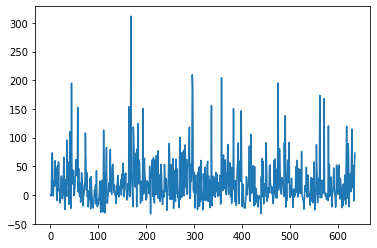

In [20]:
plt.plot(checkpoint['episode_rewards'])

In [26]:
import pandas as pd
data = pd.read_csv(path("logs-5.tsv"), sep='\t')

In [24]:
os.path.isfile(path("logs-5.tsv"))

False

In [27]:
np.mean(data['mean_episode_return'][:500])

33.47301447088669

In [1]:
def plot_episode(plots, fname, label, model = None):
    plt.figure(figsize=(12,8))
    color = 'rgb'
    for i, episode in enumerate(plots):
        np.save(path(fname), episode)
        plt.plot(np.linspace(0, 500, len(episode)), episode)
    plt.xlabel('Training episode')
    plt.ylabel(F'The {label} per episode')
    plt.title(F'{"" if model is None else model+" "}Nethack training curves tracking the agent’s {label} per episode')
    plt.show()
    plt.savefig(path(fname + '.png'))

In [37]:
data['mean_episode_return'][:500]

0            NaN
1       2.064965
2       9.679951
3      62.160175
4      51.709660
         ...    
495    82.587196
496    37.260113
497    13.474001
498          NaN
499    47.654953
Name: mean_episode_return, Length: 500, dtype: float64

In [43]:
# plt.plot(rewards_smoothed(data['mean_episode_return'][-500:], 125))

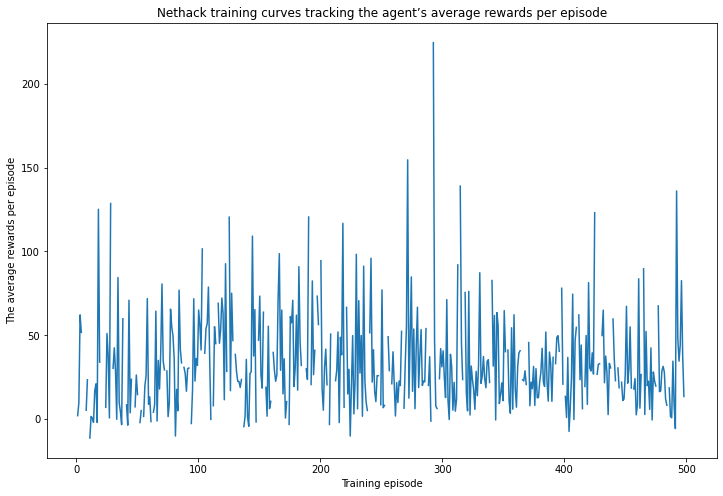

<Figure size 432x288 with 0 Axes>

In [53]:
plot_episode([data['mean_episode_return'][:500], rewards_smoothed(data['mean_episode_return'][:500], 125)], 'AC', 'average rewards')

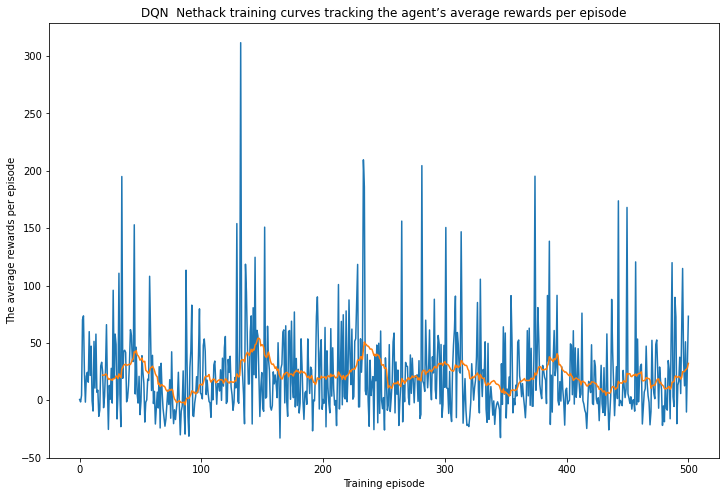

<Figure size 432x288 with 0 Axes>

In [58]:
checkpoint = torch.load(('/content/gdrive/MyDrive/Colab Notebooks/Nethack/dqn_2-636.pt'), map_location='cpu')
plot_episode([checkpoint['episode_rewards'], rewards_smoothed(checkpoint['episode_rewards'], 25)], 'DQN', 'average rewards', 'DQN ')

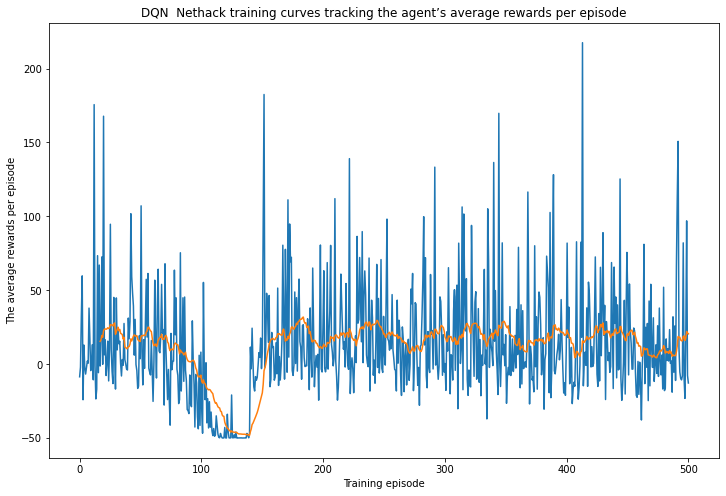

<Figure size 432x288 with 0 Axes>

In [56]:
checkpoint = torch.load(('/content/gdrive/MyDrive/Colab Notebooks/Nethack/dqn_3-714.pt'), map_location='cpu')
plot_episode([checkpoint['episode_rewards'], rewards_smoothed(checkpoint['episode_rewards'], 25)], 'DQN', 'average rewards', 'DQN ')

In [135]:
plot_episode([checkpoint['episode_rewards'], rewards_smoothed(checkpoint['episode_rewards'], 25)], 'DQN', 'average rewards', 'DQN ')

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
53939    71.168262
53940    71.037428
53941    70.899029
53942    69.076002
53943    69.281652
Name: mean_episode_return, Length: 53944, dtype: float64

In [109]:
data['mean_episode_return'][-25:-25]

Series([], Name: mean_episode_return, dtype: float64)

In [113]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [ ]:
def plot_lc(scores, title, save = False):
    fig = plt.figure()
    x = np.arange(1, len(scores)+1)
    plt.plot(x, scores, label='Score')
    m_average = moving_average(scores, 1000)
    plt.plot(x, m_average, label='Moving Average (w=50)', linestyle='--')
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(title)
    plt.show()
    if (save): plt.savefig(title + ".png")

In [161]:
# list(data['mean_episode_return']
rewards_smoothed = pd.Series(data['mean_episode_return']).rolling(125,min_periods=125).mean()

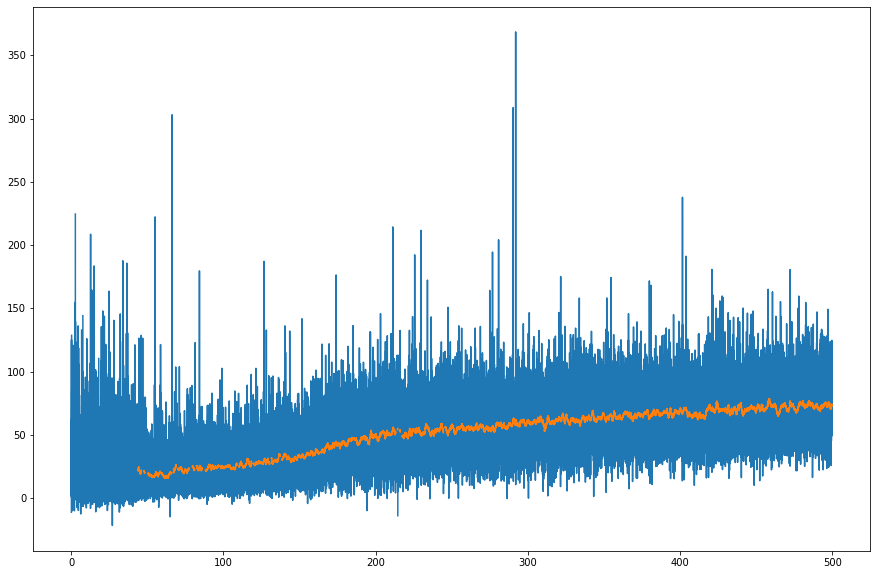

In [224]:
plt.plot(np.linspace(0, 500, len(rewards_smoothed)), data['mean_episode_return'])
plt.plot(np.linspace(0, 500, len(rewards_smoothed)), rewards_smoothed)
# plot_lc(list(data['mean_episode_return']), title='REINFORCE learning curve - CartPole-v1', save=True)

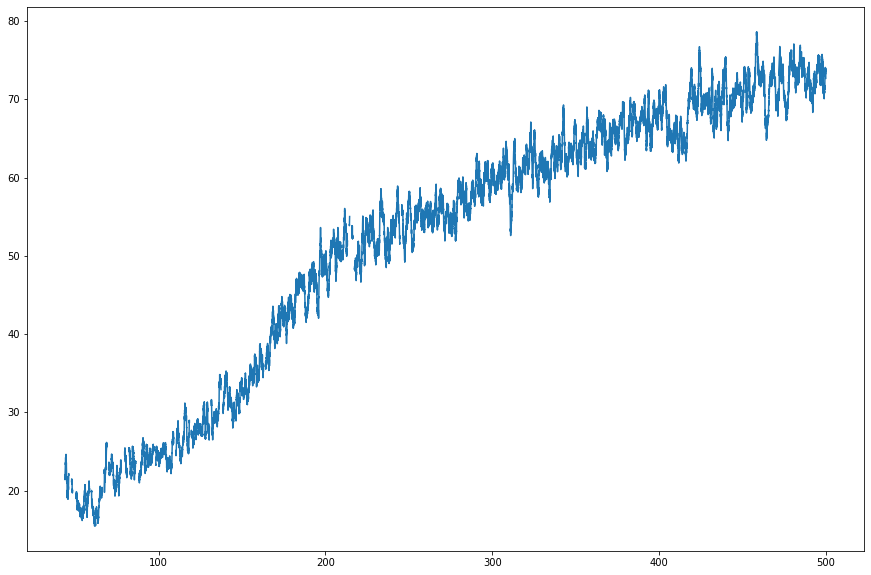

In [222]:
plt.plot(np.linspace(0, 500, len(rewards_smoothed)), rewards_smoothed)

In [23]:
def create_env(name, *args, **kwargs):
    return gym.make(name, observation_keys=("glyphs", "blstats"), *args, **kwargs)

In [29]:
def test(flags, num_episodes=10):
    flags.savedir = os.path.expandvars(os.path.expanduser(flags.savedir))
    checkpointpath = os.path.join(path("model.tar"))

    gym_env = create_env(flags.env, archivefile=None)
    env = ResettingEnvironment(gym_env)
    model = Net(gym_env.observation_space, gym_env.action_space.n, flags.use_lstm)
    model.eval()
    checkpoint = torch.load(checkpointpath, map_location="cpu")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to('cuda')

    observation = env.initial()
    returns = []

    agent_state = model.initial_state(batch_size=1)

    while len(returns) < num_episodes:
        if flags.mode == "test_render":
            env.gym_env.render()
        policy_outputs, agent_state = model(observation, agent_state)
        observation = env.step(policy_outputs["action"])
        if observation["done"].item():
            returns.append(observation["episode_return"].item())
            logging.info(
                "Episode ended after %d steps. Return: %.1f",
                observation["episode_step"].item(),
                observation["episode_return"].item(),
            )
    env.close()
    logging.info(
        "Average returns over %i steps: %.1f", num_episodes, sum(returns) / len(returns)
    )